# Worksheet 16

Name:  Viktoria Zruttova
UID: U13977544

### Topics

- Support Vector Machines (Non-linear case)

## Support Vector Machines

Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

a) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

KeyboardInterrupt: 

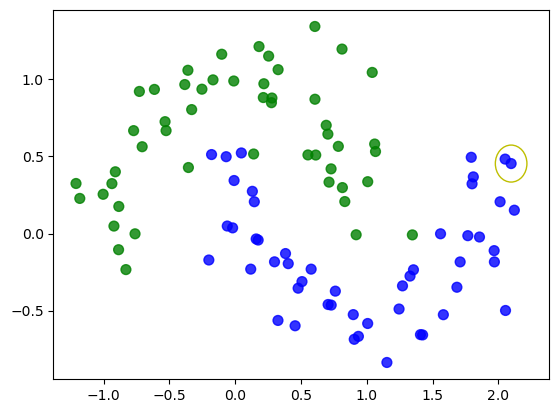

In [39]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

TEMPFILE = "temp.png"

epochs = 1000
learning_rate = .05
expanding_rate = .99
retracting_rate = 1.1

X, labels = make_moons(n_samples=100, noise=0.2, random_state=0)
Y = np.array([-1 if label == 0 else 1 for label in labels])

alpha_i = np.zeros((len(X),))
b = 0

def snap(x, alpha_i, b, error, kernel_func, *kernel_args):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y',fill=False))
   
    Z = predict_many(alpha_i, b, meshData, kernel_func, *kernel_args)

    Z = np.array([0 if z <=0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z, kernel_func, *kernel_args):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i], kernel_func, *kernel_args))
    return np.array(res)


def predict(alpha_i, b, x, kernel_func, *kernel_args):
    result = b
    for i in range(len(alpha_i)):
        result += alpha_i[i] * kernel_func(X[i], x, *kernel_args)  

    return result

def polynomial_kernel(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n


c = 1
n = 3
kernel_args = (c, n)

images = []
for _ in range(epochs):
    # Pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]

    pred_y = predict(alpha_i, b, x, polynomial_kernel, *kernel_args)

    # check for misclassification
    if y * pred_y <= 0:
        error = True
        alpha_i[i] += learning_rate
        b += learning_rate * y

    images.append(snap(x, alpha_i, b, error, polynomial_kernel, *kernel_args))


images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)


Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

In [ ]:
def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n


b) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

Decrease the number of polynomial n. Lower values of n result in smoother decision boundaries which can help generalize better to unseen data.

c) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

Increasing the value of σ makes the bell curve wider and it allows more data points to influence the decision boundary. This increases the complexity of the model and helps it capture more intricate patterns in the data. But we need to be careful to not overfit.

d) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

Parameters: c=0.1, n=2, Accuracy: 0.5128205128205128
Parameters: c=0.1, n=3, Accuracy: 0.5384615384615384
Parameters: c=0.1, n=4, Accuracy: 0.5128205128205128
Parameters: c=1, n=2, Accuracy: 0.4358974358974359
Parameters: c=1, n=3, Accuracy: 0.4358974358974359
Parameters: c=1, n=4, Accuracy: 0.4358974358974359
Parameters: c=10, n=2, Accuracy: 0.4358974358974359
Parameters: c=10, n=3, Accuracy: 0.4358974358974359
Parameters: c=10, n=4, Accuracy: 0.4358974358974359
best params: (0.1, 3)


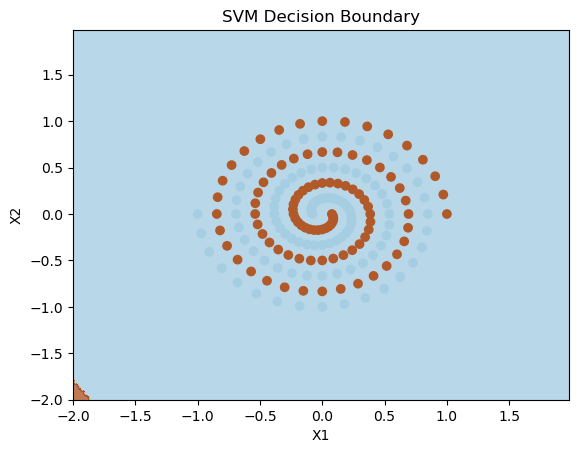

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

data = np.loadtxt("spiral.data")
x, y = data[:, :2], data[:, 2]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

def fit_svm(x_train, y_train, c, n):
    epochs = 1000
    learning_rate = 0.05
    alpha_i = np.zeros((len(x_train),))
    b = 0
    for _ in range(epochs):
        i = np.random.randint(0, len(x_train))
        error = False
        x, y = x_train[i], y_train[i]
        pred_y = predict(alpha_i, b, x, polynomial_kernel, c, n)
        if y * pred_y <= 0:
            error = True
            alpha_i[i] += learning_rate
            b += learning_rate * y
    return alpha_i, b

def polynomial_kernel(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

def predict(alpha_i, b, x, kernel_func, *kernel_args):
    result = b
    for i in range(len(alpha_i)):
        result += alpha_i[i] * kernel_func(x_train[i], x, *kernel_args)  
    return np.sign(result)

#grid search for the best parameters
best_accuracy = 0
best_params = None

for c in [0.1, 1, 10]:
    for n in [2, 3, 4]:
        alpha_i, b = fit_svm(x_train, y_train, c, n)
        correct = 0
        for i in range(len(x_test)):
            pred_y = predict(alpha_i, b, x_test[i], polynomial_kernel, c, n)
            if pred_y == y_test[i]:
                correct += 1
        accuracy = correct / len(x_test)
        print(f"Parameters: c={c}, n={n}, Accuracy: {accuracy}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (c, n)
print("best params:", best_params)


h = .02  # step size in the mesh
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = np.zeros(xx.shape)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        Z[i, j] = predict(alpha_i, b, np.array([xx[i, j], yy[i, j]]), polynomial_kernel, *best_params)

plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('SVM Decision Boundary')
plt.show()
